# Реализуемый алгоритмы
1. Метод градиентного спуска с дробным шагом
2. Метод наискорейшего спуска
# Вспомогательный код

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt

Общий класс метода и утилитарные методы:

In [13]:
import base64
import urllib.parse
import io
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from IPython.display import HTML, display
from abc import ABC, abstractmethod


class Method(ABC):

    # кортеж - (1, 2)
    @abstractmethod
    def result(self) -> tuple:
        pass

    # image - показывать ли изображение в таблице
    @abstractmethod
    def info(self, image=False) -> dict:
        pass


# В качестве особого ключа будет 'title', который будет указывать название метода
titleKey = 'title'
minPointKey = '1. Точка минимума'
minimumKey = '2. Минимум'
iterCountKey = '3. Кол-во итераций'
execCountKey = '4. Кол-во вызовов целевой функции'
gradCountKey = '5. Кол-во вычислений градиента'
imageKey = '6. График приближения'


def dictsToTable(dicts: list[dict]):
    keys = set()
    for dict in dicts:
        for key in dict.keys():
            keys.add(key)

    keys.discard('title')
    keys = list(keys)
    keys.sort()
    # формируем таблицу
    table = '<th></th>'
    for dict in dicts:
        table += '<th>' + dict[titleKey] + '</th>'

    table = '<tr>' + table + '</tr>'

    for key in keys:
        table += '<tr>'
        table += '<th>' + str(key) + '</th>'
        for dict in dicts:
            cellData = ''
            if dict.get(key) != None:
                cellData = str(dict[key])

            table += '<th>' + cellData + '</th>'

        table += '</tr>'

    display(HTML('<table style="border:20px black solid">' + table + '</table>'))


def printMethodsInfo(methods: list[Method], image=True):
    dictsToTable([method.info(image) for method in methods])


def figureToHtml(fig: Figure):
    imgdata = io.BytesIO()
    fig.savefig(imgdata, format='png', dpi=500)
    imgdata.seek(0)
    data = urllib.parse.quote(base64.b64encode(imgdata.read()).decode())
    return '<img src="data:image/png;base64,%s"/>' % data


def fmtFloat(num: float, eps: float) -> str:
    """
    Возвращает сторку с числом num, округленное до точености eps
    Пример: fmtFloat(0.125, 0.01) -> 0.13
    """
    count = -round(m.log10(eps))
    return f"{num:.{count}f}"


def drawPoints(fig: Figure, fun, points: list):
    minx = min(points, key=lambda x: x[0])[0]
    maxx = max(points, key=lambda x: x[0])[0]
    miny = min(points, key=lambda x: x[1])[1]
    maxy = max(points, key=lambda x: x[1])[1]

    deltax = (maxx - minx) / 10
    deltay = (maxy - miny) / 10

    if deltax < 0.1:
        deltax = 5
    if deltay < 0.1:
        deltay = 5

    minx -= deltax
    maxx += deltax
    miny -= deltay
    maxy += deltay

    pointsCount = 300
    X = np.linspace(minx, maxx, num=pointsCount)
    Y = np.linspace(miny, maxy, num=pointsCount)
    X, Y = np.meshgrid(X, Y)
    Z = []
    for i in range(pointsCount):
        ZZ = []
        for j in range(pointsCount):
            ZZ.append(fun([X[i, j], Y[i, j]]))
        Z.append(ZZ)

    ax = fig.subplots()
    ax.grid()
    maxLevels = 100
    levels = list(set([fun(x) for x in points[:min(maxLevels, len(points))]]))
    levels.sort()

    # maxPoints = 1000
    # points = points[:min(maxPoints, len(points))]

    ax.contour(X, Y, Z, levels=levels)
    ax.plot([x[0] for x in points], [x[1]
            for x in points], marker='o', markersize=3, color='red')


def showImage(fun, points: list, equal: bool = False):
    # перед вызовом этой функции нужно написать %matplotlib widget
    fig = plt.figure()
    drawPoints(fig, fun, points)
    figData = figureToHtml(fig)
    if equal:
        fig.gca().set_aspect('equal')

    # fig.show()
    # plt.close(fig)


Минимизируемые функции:

In [5]:
def f1(x): return 10 * x[0]**2 - 4*x[0]*x[1] + 7 * \
    x[1]**2 - 4*m.sqrt(5) * (5*x[0]-x[1]) - 16


def f1Grad(x): return [-20 * m.sqrt(5) + 20 * x[0] -
                       4*x[1], 4*m.sqrt(5) - 4*x[0] + 14*x[1]]


def rozenbrok(alpha: float):
    # return lambda x: alpha * (x[0]**2 - x[1])**2 + (x[0]-1)**2
    return lambda x: alpha * np.power(np.power(x[0], 2) - x[1], 2) + np.power(x[0]-1, 2)


def rozenbrokGrad(alpha: float):
    # return lambda x: [-2*(1 - x[0]) - 4*x[0]*(-x[0]**2 + x[1])*alpha, 2*(-x[0]**2 + x[1])*alpha]
    return lambda x: [-2*(1 - x[0]) - 4*x[0]*(-np.power(x[0], 2) + x[1])*alpha, 2*(-np.power(x[0], 2) + x[1])*alpha]


alpha1 = 1
alpha2 = 10

f2 = rozenbrok(alpha1)
f2Grad = rozenbrokGrad(alpha1)

f3 = rozenbrok(alpha2)
f3Grad = rozenbrokGrad(alpha2)


Метод золотого сечения для одномерной оптимизации:

In [4]:
def methodGoldenRatio(fun, a: float, b: float, eps: float):
    tau = (m.sqrt(5) + 1) / 2
    ak, bk = a, b
    lk = bk - ak
    xk1 = bk - (bk - ak) / tau
    xk2 = ak + (bk - ak) / tau
    y1, y2 = fun(xk1), fun(xk2)

    execCount = 2

    # while lk >= eps:
    while np.abs(bk - ak) >= eps*(np.abs(xk1) + np.abs(xk2)) and execCount <= 5002:
        execCount += 1

        if y1 >= y2:
            ak = xk1
            xk1 = xk2
            xk2 = ak + bk - xk1
            y1 = y2
            y2 = fun(xk2)
        else:
            bk = xk2
            xk2 = xk1
            xk1 = ak + bk - xk2
            y2 = y1
            y1 = fun(xk1)
        lk = bk - ak
    return (ak + bk) / 2, execCount


Метод градиентного спуска с дробным шагом:

In [10]:
class GradDescMethod(Method):

    def __init__(self, fun, grad, eps: float, startPoint, funName):
        self.points = []
        self.iterCount = 0
        self.execCount = 0
        self.gradCount = 0
        self.startPoint = startPoint
        self.fun = fun
        self.funName = funName

        # Параметры дробления шага
        # omega = 0.5
        omega = 0.6
        # delta = 0.5
        delta = 0.7
        # kappa0 = 1.0
        kappa0 = 0.9

        self.eps = eps

        # Сам метод
        kappa = kappa0

        xk = startPoint
        self.points.append(xk)
        lk = eps + 1
        while lk >= eps:
            self.iterCount += 1

            # kappa = kappa0

            gradXk = grad(xk)
            self.gradCount += 1

            fxk = fun(xk)
            self.execCount += 1

            newXk = [xk[0] - gradXk[0]*kappa, xk[1] - gradXk[1]*kappa]
            newFxk = fun(newXk)
            self.execCount += 1

            while newFxk > fxk - omega * kappa * np.linalg.norm(gradXk)**2:
                kappa *= delta
                newXk = [xk[0] - gradXk[0]*kappa, xk[1] - gradXk[1]*kappa]
                newFxk = fun(newXk)
                self.execCount += 1

            # lk = np.linalg.norm([newXk[0] - xk[0], newXk[1] - xk[1]])
            lk = np.linalg.norm(gradXk)
            # print('newXk = ', newXk, ', xk = ', xk, ', lk = ', lk)
            xk = newXk
            self.points.append(xk)

        self.minPoint = xk
        self.minimum = fun(xk)

        # if len(self.points) <= 100:
        # print(self.points)

    def result(self) -> tuple:
        return self.minPoint, self.minimum

    def info(self, image=False) -> dict:
        d = {
            titleKey: 'Метод градиентного спуска с дробным шагом',
            minPointKey: '(' + fmtFloat(self.minPoint[0], self.eps) + ', ' + fmtFloat(self.minPoint[1], self.eps) + ')',
            minimumKey: fmtFloat(self.minimum, self.eps),
            iterCountKey: self.iterCount,
            execCountKey: self.execCount,
            gradCountKey: self.gradCount,
            # imageKey: figData
        }

        if image:
            fig = plt.figure()
            drawPoints(fig, self.fun, self.points)
            figData = figureToHtml(fig)
            # fig.savefig('Метод градиентного спуска с дробным шагом, eps ' + str(self.eps) + ', start = (' +
                    # fmtFloat(self.startPoint[0], self.eps) + ', ' + fmtFloat(self.startPoint[1], self.eps) + ')' + ', ' + self.funName + '.png', dpi=600)
            plt.close(fig)
            d[imageKey] = figData

        return d


Метод наискорейшего спуска:

In [11]:
class StepDescMethod(Method):

    def __init__(self, fun, grad, eps: float, startPoint, funName):
        self.points = []
        self.iterCount = 0
        self.execCount = 0
        self.gradCount = 0
        self.funName = funName
        self.startPoint = startPoint
        maxVecLen = 400.0

        self.eps = eps

        self.fun = fun

        # Сам метод
        xk = startPoint
        self.points.append(xk)
        lk = eps + 1
        while lk >= eps:
            self.iterCount += 1

            gradXk = grad(xk)
            self.gradCount += 1

            v = gradXk
            if np.linalg.norm(v) >= maxVecLen:
                v = np.array(v) / np.linalg.norm(v) * maxVecLen

            # phi = lambda l: fun([xk[0] - gradXk[0]*l, xk[1] - gradXk[1]*l])
            phi = lambda l: fun([xk[0] - v[0]*l, xk[1] - v[1]*l])
            lam, addExec = methodGoldenRatio(
                phi,
                # вместо 2.5 можно взять другое число
                0, 1, eps
            )
            self.execCount += addExec

            # newXk = [xk[0] - gradXk[0]*lam, xk[1] - gradXk[1]*lam]
            newXk = [xk[0] - v[0]*lam, xk[1] - v[1]*lam]

            # lk = np.linalg.norm([newXk[0] - xk[0], newXk[1] - xk[1]])
            lk = np.linalg.norm(gradXk)
            xk = newXk
            self.points.append(xk)

        self.minPoint = xk
        self.minimum = fun(xk)

    def result(self) -> tuple:
        return self.minPoint, self.minimum

    def info(self, image=False) -> dict:
        d = {
            titleKey: 'Метод наискорейшего спуска',
            minPointKey: '(' + fmtFloat(self.minPoint[0], self.eps) + ', ' + fmtFloat(self.minPoint[1], self.eps) + ')',
            minimumKey: fmtFloat(self.minimum, self.eps),
            iterCountKey: self.iterCount,
            execCountKey: self.execCount,
            gradCountKey: self.gradCount,
            # imageKey: figData
        }

        if image:
            fig = plt.figure()
            drawPoints(fig, self.fun, self.points)
            figData = figureToHtml(fig)
            # fig.savefig('Метод наискорейшего спуска, eps ' + str(self.eps) + ', start = (' +
                    # fmtFloat(self.startPoint[0], self.eps) + ', ' + fmtFloat(self.startPoint[1], self.eps) + ')' + ', ' + self.funName + '.png', dpi=600)
            plt.close(fig)
            d[imageKey] = figData

        return d


# Тесты:
Одиночный тест

,Метод наискорейшего спуска
1. Точка минимума,"(1.01, 1.02)"
2. Минимум,0.00
3. Кол-во итераций,42
4. Кол-во вызовов целевой функции,596
5. Кол-во вычислений градиента,42


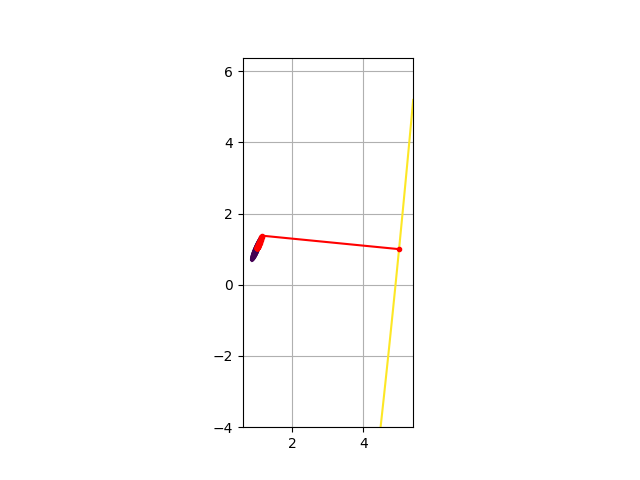

In [16]:
%matplotlib widget

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('default')

eps = 0.01
# res = StepDescMethod(f3, f3Grad, 1e-2, [6, 7], '')
res = StepDescMethod(f2, f2Grad, 1e-2, [5, 1], '')
info = res.info(image=False)
# dictsToTable([info])
printMethodsInfo([res], image=False)
showImage(res.fun, res.points, True)


Большой тест

In [14]:
import warnings
warnings.filterwarnings('ignore')

showImg = True

epss = [0.01, 1e-6]

funs = [['Квадратичная функция', f1, f1Grad], ['Функция Розенброка с \u03b1 = 1',
                                              f2, f2Grad], ['Функция Розенброка с \u03b1 = 10', f3, f3Grad]]

# funs = [['Функция Розенброка с \u03b1 = 1', f2, f2Grad], ['Функция Розенброка с \u03b1 = 10', f3, f3Grad]]


startPoints = [
    [10., 10.], [-100., -100.], [0., 0.], [1000., 1000.],
    [5., 1.], [50.0, -400.0], [50.0, 2.], [12., -5.],
    [1., 1.], [6., 7.], [2., 2.], [-5., -5.]
]

# startPoints = [
#     [5., 1.], [20., -1000.0], [50.0, 2.], [12., -5.],
#     [1., 1.], [6., 7.], [2., 2.], [-5., -5.]
# ]

for i, fun in enumerate(funs):
    for j, eps in enumerate(epss):
        ind = 2*(i*len(epss) + j)
        # ind = i*len(epss) + j
        startPoint = startPoints[ind]

        print(fun[0] + ', \u03b5 = ' + str(eps) + ', начальная точка = (' +
              str(startPoint[0]) + ', ' + str(startPoint[1]) + ')')

        res1 = GradDescMethod(fun[1], fun[2], eps, startPoint, fun[0])
        res2 = StepDescMethod(fun[1], fun[2], eps, startPoint, fun[0])
        printMethodsInfo([res1, res2], showImg)

        ind += 1
        # ind = i*len(epss) + j
        startPoint = startPoints[ind]

        print(fun[0] + ', \u03b5 = ' + str(eps) + ', начальная точка = (' +
              str(startPoint[0]) + ', ' + str(startPoint[1]) + ')')

        res1 = GradDescMethod(fun[1], fun[2], eps, startPoint, fun[0])
        res2 = StepDescMethod(fun[1], fun[2], eps, startPoint, fun[0])
        printMethodsInfo([res1, res2], showImg)


Квадратичная функция, ε = 0.01, начальная точка = (10.0, 10.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(2.24, 0.00)","(2.24, 0.00)"
2. Минимум,-66.00,-66.00
3. Кол-во итераций,11,8
4. Кол-во вызовов целевой функции,30,132
5. Кол-во вычислений градиента,11,8


Квадратичная функция, ε = 0.01, начальная точка = (-100.0, -100.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(2.24, -0.00)","(2.24, -0.00)"
2. Минимум,-66.00,-66.00
3. Кол-во итераций,14,11
4. Кол-во вызовов целевой функции,36,177
5. Кол-во вычислений градиента,14,11


Квадратичная функция, ε = 1e-06, начальная точка = (0.0, 0.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(2.236068, -0.000000)","(2.236068, -0.000000)"
2. Минимум,-66.000000,-66.000000
3. Кол-во итераций,30,11
4. Кол-во вызовов целевой функции,70,390
5. Кол-во вычислений градиента,30,11


Квадратичная функция, ε = 1e-06, начальная точка = (1000.0, 1000.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(2.236068, 0.000000)","(2.236068, -0.000000)"
2. Минимум,-66.000000,-66.000000
3. Кол-во итераций,26,12
4. Кол-во вызовов целевой функции,60,405
5. Кол-во вычислений градиента,26,12


Функция Розенброка с α = 1, ε = 0.01, начальная точка = (5.0, 1.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(1.01, 1.03)","(1.01, 1.02)"
2. Минимум,0.00,0.00
3. Кол-во итераций,3300,42
4. Кол-во вызовов целевой функции,6616,596
5. Кол-во вычислений градиента,3300,42


Функция Розенброка с α = 1, ε = 0.01, начальная точка = (50.0, -400.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(0.99, 0.97)","(0.99, 0.98)"
2. Минимум,0.00,0.00
3. Кол-во итераций,456778,76
4. Кол-во вызовов целевой функции,913585,1150
5. Кол-во вычислений градиента,456778,76


Функция Розенброка с α = 1, ε = 1e-06, начальная точка = (50.0, 2.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(1.000001, 1.000003)","(1.000001, 1.000002)"
2. Минимум,0.000000,0.000000
3. Кол-во итераций,1495628,126
4. Кол-во вызовов целевой функции,2991285,4161
5. Кол-во вычислений градиента,1495628,126


Функция Розенброка с α = 1, ε = 1e-06, начальная точка = (12.0, -5.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(0.999999, 0.999997)","(0.999999, 0.999998)"
2. Минимум,0.000000,0.000000
3. Кол-во итераций,75036,98
4. Кол-во вызовов целевой функции,150093,3227
5. Кол-во вычислений градиента,75036,98


Функция Розенброка с α = 10, ε = 0.01, начальная точка = (1.0, 1.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(1.00, 1.00)","(1.00, 1.00)"
2. Минимум,0.00,0.00
3. Кол-во итераций,1,1
4. Кол-во вызовов целевой функции,2,11
5. Кол-во вычислений градиента,1,1


Функция Розенброка с α = 10, ε = 0.01, начальная точка = (6.0, 7.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(1.01, 1.02)","(1.01, 1.02)"
2. Минимум,0.00,0.00
3. Кол-во итераций,130239,238
4. Кол-во вызовов целевой функции,260502,4353
5. Кол-во вычислений градиента,130239,238


Функция Розенброка с α = 10, ε = 1e-06, начальная точка = (2.0, 2.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(1.000001, 1.000002)","(1.000001, 1.000002)"
2. Минимум,0.000000,0.000000
3. Кол-во итераций,16659,113
4. Кол-во вызовов целевой функции,33335,4033
5. Кол-во вычислений градиента,16659,113


Функция Розенброка с α = 10, ε = 1e-06, начальная точка = (-5.0, -5.0)


,Метод градиентного спуска с дробным шагом,Метод наискорейшего спуска
1. Точка минимума,"(0.999999, 0.999998)","(0.999999, 0.999998)"
2. Минимум,0.000000,0.000000
3. Кол-во итераций,129575,1268
4. Кол-во вызовов целевой функции,259173,48089
5. Кол-во вычислений градиента,129575,1268


В зависимости:
1. от параметров точности;
2. начальной точки;
3. выпуклости (переход от квадратичной функции к функции Розенброка);
4. овражности функции (параметра α в функции Розенброка)

1. Для квадратичной функции лучше метод с дроблением шага, для ф-и Розенброка - наискорейший спуск.
2. Чем больше точность, тем больше вызовов целевой функции.
3. Выпуклость приводит к увеличению кол-во вызовов целевой функции и её градиента.
4. Увеличение овражности приводит к увеличению кол-во вызовов целевой функции и её градиента.

In [39]:
print('text')
from IPython.display import display, Markdown
print('title')
display(Markdown("""# title
## *tt*"""))

text
title


# title
## *tt*